### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
#import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

### Params

In [2]:
result_filename = 'model-02-build-keras-search'

In [3]:
is_log_target = True
is_per_area_target = True
is_embedding = True
is_tar_encoded = False

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]
cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_bin_add = []

# cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

print('Target:', col_target)

Target: log_per_area_total_price


In [4]:
# Feature remove
# PARS #
N_feats_rm = 67
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Columns

In [5]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']

print('Total (before remove):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))

cols_num = [c for c in cols_num if c not in feats_rm]
cols_bin = [c for c in cols_bin if c not in feats_rm]
cols_cat = [c for c in cols_cat if c not in feats_rm]

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']

# right skew cols
#cols_right_skew = ['parking_area', 'land_area', 'building_area']+[c for c in cols_num if 'MIN' in c]

# For Stratified train test split
#cols_stratified = ['town', 'village']

print('Num:', len(cols_num), 'Bin:', len(cols_bin), 'Cat:', len(cols_cat))
print('Add:', len(cols_num_add), len(cols_bin_add), len(cols_cat_add), 
      'Total (after):', 
      len(cols_num)+len(cols_bin)+len(cols_cat)+len(cols_num_add)+len(cols_bin_add)+len(cols_cat_add))
#print('Right skew:', cols_right_skew)
#print('Total:', len(cols_feats))

Total (before remove): 213
Num: 130 Bin: 7 Cat: 7
Add: 1 0 1 Total (after): 146


### Read data

In [6]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,9,1,53,1,1435,1,4611,1,145.27967019169262,987021.4150420949
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738411744735565,...,88,1,316,1,5659,1,22826,1,18.81499793345573,15725223.997450478
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,113,1,348,1,13252,1,32687,1,94.79959334423607,11815402.03862225
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,23,1,142,1,5317,1,21087,1,33.10458025153816,18084995.81999832
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,75,1,249,1,15417,1,32826,1,47.50987600102272,8510295.87633061


shape = (60000, 235)


### Preprocessing

In [7]:
def pre_processing(df, cols_num, cols_cat, cols_bin):
    """Preprocess (inplace) that are independent of train and validatoin set"""
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    df[cols_bin] = df[cols_bin].astype('float32')
    df[cols_cat] = df[cols_cat].astype('int32')
    
    # target transform base (store this for inverse transform)
    if is_per_area_target:
        df['building_area_ori'] = df['building_area']
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area_ori']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
    
    # fix town and city
    #df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
    #df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    return df

In [8]:
def post_processing(y_pred, df):
    """Post processing target
       Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area_ori'].values
        
    return y_pred_final

In [9]:
df = pre_processing(df, cols_num, cols_cat, cols_bin)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [10]:
# Add those added feature columns (run this after preprocess has done)
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_bin = cols_bin + [c for c in cols_bin_add if c not in cols_bin]
cols_feats = cols_num + cols_cat + cols_bin
print('Feat columns:', cols_feats)

# Target mean encoded columns
cols_tar_encoded = ['encoded_'+c for c in cols_cat] if is_tar_encoded else []
    
print('\nTarget mean encoded columns:', cols_tar_encoded)

# Compute skew columns
cols_right_skew = [c for c in cols_num if df[c].skew() > 2.2]
print('\nRight skew columns:', cols_right_skew)

# Fillna values for null columns
fillna_values = {
    'parking_area': -1.,
    'parking_price': -1.,
    'txn_floor': 0.,
    #'village_income_median': 'median',
}

Feat columns: ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'N_50', 'N_1000', 'N_5000', 'N_10000', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_50', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII

### Feature engineering
Include cat encoding, fillna, scaling

In [11]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import PdStandardScaler, PdMedianScaler, PdMinMaxScaler

In [12]:
class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_bin, col_target, 
                 fillna_values={}, cols_right_skew=[], is_embedding=False, is_tar_encoded=True,
                 n_ran_encode=4, rare_village_threshold=2, rare_town_threshold=2):
        # Cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_bin = cols_bin
        self.col_target = col_target
        self.cols_right_skew = cols_right_skew
        
        # Numbers
        #self.n_ran_encode = n_ran_encode
        
        # Rare village and town
        self.rare_town_threshold = rare_town_threshold
        self.rare_village_threshold = rare_village_threshold
        
        # Cat encoders
        self.is_tar_encoded = is_tar_encoded
        if is_tar_encoded:
            self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.is_embedding = is_embedding
        if is_embedding:
            self.cat_astyper = CategoricalColumnsEncoder(mode='keras', reserve_missing=True)
        
        # Fillna
        self.fillna_values = fillna_values
        
        # Skewness
        self.mins_right_skew_cols = {}  # map from the col name to the original min
        
        # Normalization
        self.scaler = PdStandardScaler()
        
        # Target normalization
        self.target_scaler = PdStandardScaler()
        
    def fit_transform(self, df):
        df = df.copy()   
        
        # Rare village
        village_counts = df['village'].value_counts()
        rare_village = set(village_counts.index[village_counts <= self.rare_village_threshold])
        df.loc[df['village'].isin(rare_village), 'village'] = np.nan
        town_counts = df['town'].value_counts()
        rare_town = set(town_counts.index[town_counts <= self.rare_town_threshold])
        df.loc[df['town'].isin(rare_town), 'town'] = np.nan
        
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
            self.cols_tar_encoded = [c for c in df_tar_encoded]
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        else:
            self.cols_tar_encoded = []
        #encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        if self.is_embedding:
            self.cat_astyper.fit_transform(df, self.cols_cat)
        
        # Fillna
        self.fillna_values['village_income_median'] = df['village_income_median'].median()
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)
    
        # Skewness
        for c in self.cols_right_skew:
            # if the minimum of the col < 0, then subtract the min first (to make it positive)
            self.mins_right_skew_cols[c] = min(df[c].min(), 0)
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
    
        # Normalization
        self.scaler.fit(df, cols=self.cols_num+self.cols_tar_encoded)
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        assert self.col_target in df, 'Target column not found in the dataframe'
        self.target_scaler.fit(df, cols=[self.col_target])
        self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        # Cat encoders
        if self.is_tar_encoded:
            df_tar_encoded = self.tar_encoder.transform(df[self.cols_cat])
            for c in df_tar_encoded:
                df[c] = df_tar_encoded[c].astype('float32')
        #encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        if self.is_embedding:
            self.cat_astyper.transform(df)
    
        # Fillna
        for c, v in self.fillna_values.items():
            df[c] = df[c].fillna(v)    

        # Skewness
        for c in self.cols_right_skew:
            df[c] = np.log10(0.1 + df[c] - self.mins_right_skew_cols[c]).astype('float32')
        
        # Normalization
        self.scaler.transform(df)  # transform inplace!
        
        # Target normalization
        if self.col_target in df:
            self.target_scaler.transform(df, cols_input=[self.col_target], cols_transformed=[self.col_target+'_scaled'])
        
        return df
        #return pd.concat([df, encoded1, encoded2], axis=1)
        
    def target_inverse_transform(self, df, col_scaled_target, col_unscaled_target):
        self.target_scaler.inverse_transform(df, cols_input=[col_scaled_target], 
                                             cols_transformed=[col_unscaled_target])
        return df[col_unscaled_target]

### Keras Model

In [13]:
import keras
import tensorflow as tf
print('keras:', keras.__version__, 'tensorflow:', tf.__version__)

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Activation, Add
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


keras: 2.2.4 tensorflow: 1.14.0


In [14]:
from keras_get_best import GetBest
from keras_SGDRScheduler import SGDRScheduler

In [25]:
def build_model(n_cols_num_bin, cat_n_classes={}, cat_embed_sizes={}, 
                n_neurons=(1024,)*10, learning_rate=0.001, optimizer=Adam, loss='mse', 
                skip_connection=False, batch_norm=False, activation='relu', dropout=0.,
                **ignored):
    '''Args: 
       n_cols_num_bin: number of numerical and binary features
       cat_n_classes: dict of cat column name to number of classes in the cat column
       cat_embed_sizes: dict of cat column name to embedding output size
       n_neurons: list of number of neurons for each dense layer
    '''
    if skip_connection:
        assert all([x==n_neurons[0] for x in n_neurons]), 'Residual connection only work' \
            ' for square shape network'
    is_embedding = len(cat_n_classes) > 0
    num_bin_input = Input(shape=(n_cols_num_bin,), dtype='float32', name='num_bin')
    cats_inputs = {c: Input(shape=(1,), dtype='int32', name=c) for c in cat_n_classes}
    if is_embedding:
        cats_embedding_layers = [
            Reshape(target_shape=(cat_embed_sizes[c],))(
                Embedding(input_dim=c_input_dim, output_dim=cat_embed_sizes[c])(cats_inputs[c])
            ) 
            for c, c_input_dim in cat_n_classes.items()
        ]
        x_layer = concatenate([num_bin_input]+cats_embedding_layers)  # output shape = 258
    else:
        x_layer = num_bin_input
    for i, n in enumerate(n_neurons):
        if skip_connection and i%2 == 1:
            skip_layer = x_layer
        x_layer = Dense(n)(x_layer)
        x_layer = Activation(activation)(x_layer)
        if dropout > 0. and i < len(n_neurons)-1:
            x_layer = Dropout(dropout)(x_layer)
        if batch_norm:
            x_layer = BatchNormalization()(x_layer)
        if skip_connection and i%2 == 0 and i > 0:
            x_layer = Add()([x_layer, skip_layer])
    output = Dense(1)(x_layer)
    model = Model(inputs=[num_bin_input]+list(cats_inputs.values()),
                  outputs=output)
    metrics = [m for m in ['mse', 'mae'] if m != loss]
    model.compile(optimizer=optimizer(lr=learning_rate), loss=loss, metrics=metrics)
    return model    

def build_features_matrices(df, cols_num, cols_cat, cols_bin):
    Xs = {'num_bin': df[cols_num+cols_bin].values}
    for c in cols_cat:
        Xs[c] = df[c].values
    return Xs

def plot_keras_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].history.keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist.history:
                if c.endswith(m):
                    plt.plot(hist.history[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

def plot_list_hist(hists, ylim=None, metrics_plot=None, labels=None):
    if not isinstance(hists, list): hists=[hists]
    if metrics_plot is None:
        metrics_plot = [c for c in hists[0].keys() if not c.startswith('val')]
    if labels is None:
        labels = [str(i) for i in range(len(hists))]
    for m in metrics_plot:
        plt.figure(figsize=(14, 4))
        for label, hist in zip(labels, hists):
            for c in hist:
                if c.endswith(m):
                    plt.plot(hist[c], label=c+' '+label, alpha=0.9)
        if ylim != None:
            plt.ylim(*ylim)
        plt.xlabel('epochs'); plt.title(m)
        plt.legend(); plt.grid(); plt.show()

#### One run testing

In [17]:
from sklearn.model_selection import train_test_split
itrain, ival = train_test_split(df.index, test_size=0.3, random_state=123)

# split train, val
df_train = df.loc[itrain].reset_index(drop=True)
df_val = df.loc[ival].reset_index(drop=True)

# feat eng
feat_eng = FeatureEngineering(cols_num=cols_num, 
                              cols_cat=cols_cat, 
                              cols_bin=cols_bin, 
                              col_target=col_target, 
                              fillna_values=fillna_values, 
                              cols_right_skew=cols_right_skew,
                              is_embedding=is_embedding, 
                              is_tar_encoded=is_tar_encoded,)
df_train = feat_eng.fit_transform(df_train)
df_val = feat_eng.transform(df_val)

In [18]:
df_train.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,quarter_txn_dt,year_txn_dt,dow_building_complete_dt,day_in_year_building_complete_dt,month_building_complete_dt,quarter_building_complete_dt,year_building_complete_dt,dt_diff_building_complete_dt_txn_dt,land_per_building_area,log_per_area_total_price_scaled
0,T1JoS1XWqso1c9G0,6,8,-1.291672,1.252125,1,3,0.722059,1,-0.233173,...,3,50,3,315,10,3,38,4370.0,-0.613060,1.491160
1,UMyDRljT7Ze4l3eJ,6,7,-1.685994,-0.519756,4,3,1.310622,3,-0.233173,...,0,50,5,317,10,3,45,1527.0,1.100474,-1.202731
2,mTdaS1xzULNW1Ubm,6,4,-1.492969,2.630255,1,3,0.932211,1,-0.233173,...,1,50,6,133,4,1,41,3311.0,-2.214306,0.155702
3,D1bHnOx451bxG5R7,6,4,0.572396,-0.716632,3,3,-1.288767,3,-0.233173,...,2,54,3,339,11,3,14,14458.0,1.177113,0.716418
4,WyxmUEFOTLygBMgo,6,11,-0.931819,-0.716632,5,3,-0.055478,3,-0.233173,...,2,51,6,222,7,2,29,8009.0,0.355260,-2.034560
41995,QQ3yQPoujssJczPs,6,9,-1.523302,-0.519756,5,2,0.252728,3,-0.233173,...,1,50,1,101,3,1,33,6241.0,-0.505959,-0.774163
41996,rM5ZZL8I50csvris,1,6,-0.423060,-1.110384,5,3,-1.113602,3,-0.233173,...,2,52,1,5,0,0,17,12975.0,1.290049,-1.208087
41997,A89t9bkUOCxJdj4J,6,7,-0.438227,3.024006,1,3,1.850157,1,-0.233173,...,2,52,4,106,3,1,52,88.0,-2.062534,0.351608
41998,EPFQhBNpBs5R9CmA,6,8,-0.838064,-0.126005,4,6,1.289676,1,-0.233173,...,2,51,5,226,7,2,45,2233.0,-0.456998,2.089187
41999,iOoWvOrsv16kBvsw,6,8,0.430385,-0.716632,2,3,-1.856153,3,-0.233173,...,1,54,2,64,2,0,8,16820.0,0.593327,1.780517


shape = (42000, 254)


In [19]:
for c in cols_cat:
    print(c, df_train[c].min(), df_val[c].min())

building_material 1 1
city 1 1
building_type 1 1
building_use 1 1
parking_way 1 1
town 0 0
village 0 0
encoded_latlon 1 1


In [20]:
# Prepare X y matrices
if is_embedding:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
else:
    X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)

y_train = df_train[col_target+'_scaled']
y_val = df_val[col_target+'_scaled']

In [21]:
n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
if is_embedding:
    cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
    cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
else:
    cat_n_classes = {}
    cat_embed_sizes = {}
print('Numerical input dims:', n_cols_num_bin)
print('Embeding  input dims:', cat_n_classes)
print('Embeding output dims:', cat_embed_sizes)
print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

Numerical input dims: 138
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 196, 'village': 2229, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56


In [93]:
model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes)

In [94]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
building_material (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
city (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
building_type (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
building_use (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
parking_wa

In [71]:
def n_params(n_neurons, n_inputs=194):
    """ Compute N of parameters for the dense layers """
    n_params = n_neurons[0]*(n_inputs+1)
    for i in range(1, len(n_neurons)):
        n_params += (n_neurons[i-1]+1)*n_neurons[i]
    n_params += (n_neurons[-1]+1)
    return n_params

def solve_2nd_order_equation(a, b, c):
    """ Solve a*x^2 +b*x + c == 0 for x """
    return (-b+np.sqrt(b**2 - 4*a*c)) / (2*a) 

def solve_width_for_ratio(ratios, params, n_inputs=194):
    """ Solve the width given ratio for each layers and the total params.
        Assume the layers to be (width*ratios[0], width*ratios[1], width*ratios[2], ...)
    """
    b = ratios[0]*(n_inputs+1)
    a = 0
    for i in range(1, len(ratios)):
        a += ratios[i-1]*ratios[i]
        b += ratios[i]
    b += ratios[-1]
    c = 1 - params
    #print(a, b, c)
    return solve_2nd_order_equation(a, b, c)

def best_n_neurons(ratios, params, n_inputs=194):
    width = int(round(solve_width_for_ratio(ratios, params, n_inputs)))
    return tuple([width*x for x in ratios])

In [91]:
print(best_n_neurons(ratios=(1,)*10, params=9647105, n_inputs=194))
print(best_n_neurons(ratios=(1,)*4, params=9647105, n_inputs=194))
print(best_n_neurons(ratios=(8,4,2,1), params=9647105, n_inputs=194))
print(best_n_neurons(ratios=(1,2,4,8), params=9647105, n_inputs=194))
print(best_n_neurons(ratios=(4,8,2,1), params=9647105, n_inputs=194))
#print(best_n_neurons(ratios=(4,2,1,1), params=9647105, n_inputs=194))

(1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024)
(1760, 1760, 1760, 1760)
(3688, 1844, 922, 461)
(477, 954, 1908, 3816)
(1724, 3448, 862, 431)


In [81]:
build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, n_neurons=(3604, 1802, 901, 901)).count_params()

9675169

In [82]:
build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, n_neurons=(1024,)*10).count_params()

9685177

In [85]:
build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, n_neurons=(1024,)*10, skip_connection=True, batch_norm=False, activation='relu', dropout=0.).count_params()

9685177

In [86]:
build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, n_neurons=(1024,)*10, skip_connection=True, batch_norm=True, activation='relu', dropout=0.).count_params()

9726137

In [87]:
build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, n_neurons=(1024,)*10, skip_connection=False, batch_norm=True, activation='relu', dropout=0.).count_params()

9726137

In [88]:
build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, n_neurons=(1024,)*10, skip_connection=False, batch_norm=True, activation='relu', dropout=0.2).count_params()

9726137

In [88]:
build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, n_neurons=(1024,)*10, skip_connection=False, batch_norm=True, activation='relu', dropout=0.2).count_params()

9726137

In [37]:
%%time
hist = model.fit(x=X_train, y=y_train, batch_size=128, epochs=7, verbose=2, 
                 validation_data=(X_val, y_val), callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])

Train on 40000 samples, validate on 20000 samples
Epoch 1/7
 - 11s - loss: 1.0186 - mean_absolute_error: 0.6805 - val_loss: 0.1250 - val_mean_absolute_error: 0.2605
Epoch 2/7
 - 11s - loss: 0.1279 - mean_absolute_error: 0.2690 - val_loss: 0.1022 - val_mean_absolute_error: 0.2352
Epoch 3/7
 - 10s - loss: 0.1081 - mean_absolute_error: 0.2463 - val_loss: 0.1078 - val_mean_absolute_error: 0.2460
Epoch 4/7
 - 11s - loss: 0.0994 - mean_absolute_error: 0.2364 - val_loss: 0.0917 - val_mean_absolute_error: 0.2233
Epoch 5/7
 - 10s - loss: 0.0932 - mean_absolute_error: 0.2291 - val_loss: 0.0879 - val_mean_absolute_error: 0.2174
Epoch 6/7
 - 10s - loss: 0.0870 - mean_absolute_error: 0.2210 - val_loss: 0.0945 - val_mean_absolute_error: 0.2285
Epoch 7/7
 - 10s - loss: 0.0846 - mean_absolute_error: 0.2176 - val_loss: 0.0877 - val_mean_absolute_error: 0.2205
CPU times: user 7min 23s, sys: 2min 4s, total: 9min 27s
Wall time: 1min 15s


In [30]:
model.evaluate(X_val, y_val, batch_size=1024)

18000/18000 [==============================] - 1s 34us/step


[0.08724388343095779, 0.21872330809964075]

- loss: 0.0060 - mean_absolute_error: 0.0586 - val_loss: 0.0639 - val_mean_absolute_error: 0.1781 mse 100
- loss: 0.0031 - mean_absolute_error: 0.0404 - val_loss: 0.0600 - val_mean_absolute_error: 0.1691 256*7 mse 100
- loss: 0.0035 - mean_absolute_error: 0.0416 - val_loss: 0.0579 - val_mean_absolute_error: 0.1650 512*9 mse 100 16m
- loss: 0.0527 - mean_squared_error: 0.0076 - val_loss: 0.1677 - val_mean_squared_error: 0.0600 256*7 mae 100 3m
- loss: 0.0176 - mean_squared_error: 0.0013 - val_loss: 0.1611 - val_mean_squared_error: 0.0575 1024*10 mae 500 6h (40s/ep)
- loss: 0.0250 - mean_squared_error: 0.0023 - val_loss: 0.1600 - val_mean_squared_error: 0.0567 512*9 mae 200 26min embedding

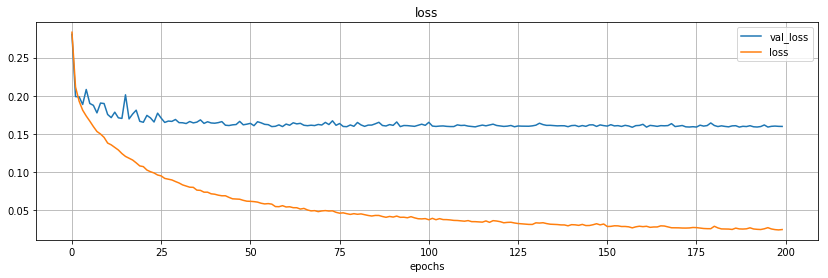

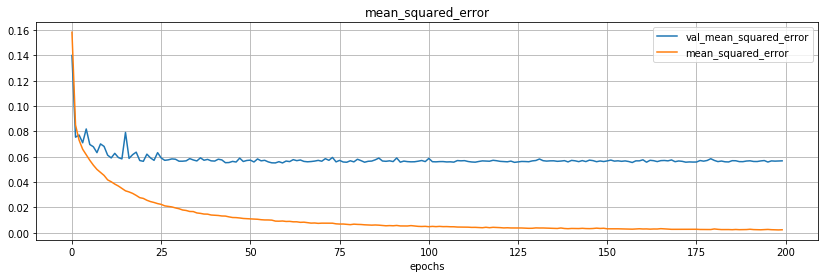

In [47]:
plot_keras_hist(hist)

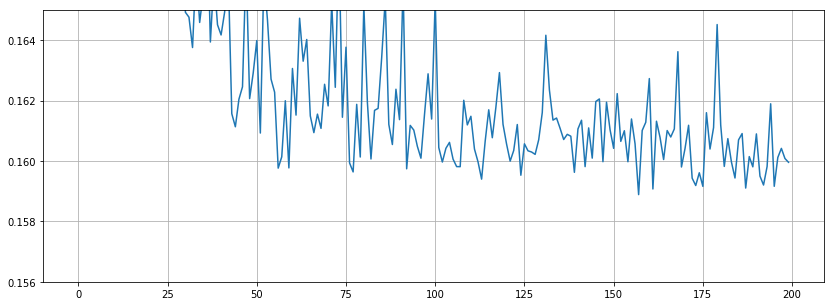

In [48]:
plt.figure(figsize=(14, 5))
plt.plot(hist.history['val_loss'])
plt.ylim(0.156, 0.165)
plt.grid(); plt.show()

In [49]:
df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)
feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred');
df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
score = cal_score(df_val['total_price'], df_val['total_price_pred'])
print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

score, mse, mae, mape: 4904.84186, 0.05174, 0.15349, 0.01151


- score, mse, mae, mape: 4551.83065, 0.05603, 0.16341, 0.01224 - 256*7 mse
- score, mse, mae, mape: 4643.83454, 0.05401, 0.15939, 0.01194 - 512*9 mse
- score, mse, mae, mape: 4659.83019, 0.05596, 0.16203, 0.01215 - 256*7 mae
- score, mse, mae, mape: 4956.84128, 0.05138, 0.15199, 0.01140 - 1024*10 mae
- score, mse, mae, mape: 4904.84186, 0.05174, 0.15349, 0.01151 - 512*9 mae embedding

In [50]:
df_val.loc[:, [col_target, col_target+'_pred', col_target+'_scaled', col_target+'_scaled_pred', 'total_price', 'total_price_pred']].check()

,log_per_area_total_price,log_per_area_total_price_pred,log_per_area_total_price_scaled,log_per_area_total_price_scaled_pred,total_price,total_price_pred
0,13.959702,13.938886,0.458847,0.437300,10673093.0,10453208.00
1,15.000397,15.182835,1.536101,1.724948,41609072.0,49936712.00
2,14.075616,14.170592,0.578833,0.677146,19443270.0,21380460.00
3,14.225937,14.429402,0.734434,0.945047,5152761.0,6315444.50
4,14.565749,14.454112,1.086184,0.970625,13297622.0,11892979.00
17995,13.969596,13.667778,0.469088,0.156668,36400320.0,26917036.00
17996,14.226914,13.816492,0.735446,0.310606,7743181.5,5136595.00
17997,14.350793,14.280404,0.863676,0.790815,5152761.0,4802533.00
17998,12.829416,12.788353,-0.711145,-0.753651,4850049.0,4654924.00
17999,13.777486,13.291307,0.270230,-0.233028,4725499.5,2906047.75


shape = (18000, 6)


### Grid search

In [16]:
# grid search
params_fix = {'epochs': 1,
              'learning_rate': 0.001,
              'batch_size': 64,
              'loss': 'mse',
             }

# prvs baseline best estimator
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

params_gsearch = {}
N_fold = 3
N_iter = 0
score_low_bound = 0 # if score smaller than this, skip the param set

#### Round 1

In [17]:
# Round 1
rand_params_set = [
    dict(n_neurons=(1024,)*10, optimizer=Adam, skip_connection=False, batch_norm=False, activation='relu', dropout=0.),
    dict(n_neurons=(1024,)*10, optimizer=Adam, skip_connection=False, batch_norm=True, activation='relu', dropout=0.),
    dict(n_neurons=(1024,)*10, optimizer=Adam, skip_connection=True, batch_norm=True, activation='relu', dropout=0.),
    dict(n_neurons=(1760, 1760, 1760, 1760), optimizer=Adam, skip_connection=False, batch_norm=False, activation='relu', dropout=0.),
    dict(n_neurons=(477, 954, 1908, 3816), optimizer=Adam, skip_connection=False, batch_norm=False, activation='relu', dropout=0.),
    dict(n_neurons=(1724, 3448, 862, 431), optimizer=Adam, skip_connection=False, batch_norm=False, activation='relu', dropout=0.),
    dict(n_neurons=(3688, 1844, 922, 461), optimizer=Adam, skip_connection=False, batch_norm=False, activation='relu', dropout=0.),
    dict(n_neurons=(1024,)*10, optimizer=Adam, skip_connection=False, batch_norm=False, activation='relu', dropout=0.15),
    dict(n_neurons=(1024,)*10, optimizer=Adam, skip_connection=False, batch_norm=False, activation='softplus', dropout=0.),
    dict(n_neurons=(1024,)*10, optimizer=SGD, skip_connection=False, batch_norm=False, activation='relu', dropout=0.),
]
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [18]:
rand_params_set

[{'n_neurons': (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024),
  'optimizer': keras.optimizers.Adam,
  'skip_connection': False,
  'batch_norm': False,
  'activation': 'relu',
  'dropout': 0.0},
 {'n_neurons': (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024),
  'optimizer': keras.optimizers.Adam,
  'skip_connection': False,
  'batch_norm': True,
  'activation': 'relu',
  'dropout': 0.0},
 {'n_neurons': (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024),
  'optimizer': keras.optimizers.Adam,
  'skip_connection': True,
  'batch_norm': True,
  'activation': 'relu',
  'dropout': 0.0},
 {'n_neurons': (1760, 1760, 1760, 1760),
  'optimizer': keras.optimizers.Adam,
  'skip_connection': False,
  'batch_norm': False,
  'activation': 'relu',
  'dropout': 0.0},
 {'n_neurons': (477, 954, 1908, 3816),
  'optimizer': keras.optimizers.Adam,
  'skip_connection': False,
  'batch_norm': False,
  'activation': 'relu',
  'dropout': 0.0},
 {'n_neurons': (1724, 3448, 862,

In [24]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain].reset_index(drop=True)
    df_val = df.loc[ival].reset_index(drop=True)

    # feat eng
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Prepare X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
        cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
    else:
        cat_n_classes = {}
        cat_embed_sizes = {}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update( params_rand )
        
        model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, **params)

        hist = model.fit(x=X_train, y=y_train, verbose=2, validation_data=(X_val, y_val), 
                         callbacks=[GetBest(monitor='val_mean_absolute_error', verbose=0, mode='min')], 
                         batch_size=params['batch_size'], epochs=params['epochs'])

        df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)

        feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
        df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
        
        mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
        mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
        mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
        score = cal_score(df_val['total_price'], df_val['total_price_pred'])
        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(hist)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] 
                   for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====


W0630 20:44:31.524606 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 20:44:31.543848 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 20:44:31.544918 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numerical input dims: 138
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 196, 'village': 2201, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56


W0630 20:44:31.848492 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0630 20:44:32.044794 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0630 20:44:32.313285 140735989851008 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 40000 samples, validate on 20000 samples
Epoch 1/1
 - 70s - loss: 0.1907 - mean_absolute_error: 0.2784 - val_loss: 0.0892 - val_mean_absolute_error: 0.2216
params: {'epochs': 1, 'learning_rate': 0.001, 'batch_size': 64, 'loss': 'mse', 'n_neurons': (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024), 'optimizer': <class 'keras.optimizers.Adam'>, 'skip_connection': False, 'batch_norm': False, 'activation': 'relu', 'dropout': 0.0}
score, mse, mae, mape: 3202.76571, 0.08341, 0.21431, 0.01618
Train on 40000 samples, validate on 20000 samples
Epoch 1/1
 - 77s - loss: 0.4061 - mean_absolute_error: 0.4197 - val_loss: 0.1328 - val_mean_absolute_error: 0.2772
params: {'epochs': 1, 'learning_rate': 0.001, 'batch_size': 64, 'loss': 'mse', 'n_neurons': (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024), 'optimizer': <class 'keras.optimizers.Adam'>, 'skip_connection': False, 'batch_norm': True, 'activation': 'relu', 'dropout': 0.0}
score, mse, mae, mape: 2519.72123, 0.124

W0630 20:54:44.411736 140735989851008 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


params: {'epochs': 1, 'learning_rate': 0.001, 'batch_size': 64, 'loss': 'mse', 'n_neurons': (3688, 1844, 922, 461), 'optimizer': <class 'keras.optimizers.Adam'>, 'skip_connection': False, 'batch_norm': False, 'activation': 'relu', 'dropout': 0.0}
score, mse, mae, mape: 3418.79150, 0.07310, 0.19843, 0.01483
Train on 40000 samples, validate on 20000 samples
Epoch 1/1
 - 82s - loss: 0.1674 - mean_absolute_error: 0.3000 - val_loss: 0.0866 - val_mean_absolute_error: 0.2162
params: {'epochs': 1, 'learning_rate': 0.001, 'batch_size': 64, 'loss': 'mse', 'n_neurons': (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024), 'optimizer': <class 'keras.optimizers.Adam'>, 'skip_connection': False, 'batch_norm': False, 'activation': 'relu', 'dropout': 0.15}
score, mse, mae, mape: 3336.77811, 0.08095, 0.20901, 0.01565
Train on 40000 samples, validate on 20000 samples
Epoch 1/1
 - 76s - loss: 5.5582 - mean_absolute_error: 0.6559 - val_loss: 0.1379 - val_mean_absolute_error: 0.2826
params: {'epoch

params: {'epochs': 1, 'learning_rate': 0.001, 'batch_size': 64, 'loss': 'mse', 'n_neurons': (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024), 'optimizer': <class 'keras.optimizers.Adam'>, 'skip_connection': False, 'batch_norm': True, 'activation': 'relu', 'dropout': 0.0}
score, mse, mae, mape: 2532.72645, 0.12429, 0.26456, 0.01972
Train on 40000 samples, validate on 20000 samples
Epoch 1/1
 - 81s - loss: 0.4212 - mean_absolute_error: 0.3921 - val_loss: 0.1119 - val_mean_absolute_error: 0.2512
params: {'epochs': 1, 'learning_rate': 0.001, 'batch_size': 64, 'loss': 'mse', 'n_neurons': (1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024), 'optimizer': <class 'keras.optimizers.Adam'>, 'skip_connection': True, 'batch_norm': True, 'activation': 'relu', 'dropout': 0.0}
score, mse, mae, mape: 2778.75581, 0.10405, 0.24222, 0.01798
Train on 40000 samples, validate on 20000 samples
Epoch 1/1
 - 80s - loss: 0.1287 - mean_absolute_error: 0.2556 - val_loss: 0.0846 - val_mean_abso

In [25]:
print('Total computing time:', t1-t0)

Total computing time: 2591.9073662757874


In [60]:
dict(gsearch_results[0][0])

{'epochs': 1,
 'learning_rate': 0.001,
 'batch_size': 64,
 'loss': 'mse',
 'n_neurons': (1760, 1760, 1760, 1760),
 'optimizer': keras.optimizers.Adam,
 'skip_connection': False,
 'batch_norm': False,
 'activation': 'relu',
 'dropout': 0.0}

In [26]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('epochs', 1), ('learning_rate', 0.001), ('batch_size', 64), ('loss', 'mse'), ('n_neurons', (1760, 1760, 1760, 1760)), ('optimizer', <class 'keras.optimizers.Adam'>), ('skip_connection', False), ('batch_norm', False), ('activation', 'relu'), ('dropout', 0.0)) 3435.4584399312735 0.076402254 0.2015387 0.01502839 [3348.785154953599, 3488.7976796627045, 3468.792485177517] [0.07794865, 0.07255726, 0.07870086] [0.203774, 0.19669756, 0.20414454] [0.015210649, 0.014682168, 0.015192352]
(('epochs', 1), ('learning_rate', 0.001), ('batch_size', 64), ('loss', 'mse'), ('n_neurons', (3688, 1844, 922, 461)), ('optimizer', <class 'keras.optimizers.Adam'>), ('skip_connection', False), ('batch_norm', False), ('activation', 'relu'), ('dropout', 0.0)) 3320.1127863277993 0.08027189 0.20746547 0.015534301 [3418.791503533721, 3214.784830957651, 3326.7620244920254] [0.073098645, 0.08962473, 0.07809231] [0.1984342, 0.21883506, 0.20512715] [0.014825757, 0.016356995, 0.015420152]
(('epochs', 1), ('learning_rate

In [22]:
metrics = ['score', 'mse', 'mae', 'mape']

In [61]:
metrics = ['score', 'mse', 'mae', 'mape']

df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['history'] = [h.history for h in row[5]]
    result['best_iterations'] = [np.argmax(h.history['val_mean_absolute_error'])+1 for h in row[5]]
    result['mean_best_iterations'] = np.mean(result['best_iterations'])
    if 'optimizer' in result:
        result['optimizer'] = str(result['optimizer'])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[
    metrics+[c for c in df_gsearch_results if c not in metrics and c != 'history']+['history']]
display(df_gsearch_results)

,score,mse,mae,mape,activation,batch_norm,batch_size,best_iterations,dropout,epochs,learning_rate,loss,mean_best_iterations,n_neurons,optimizer,skip_connection,history
0,3435.458440,0.076402,0.201539,0.015028,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,1.0,"(1760, 1760, 1760, 1760)",<class 'keras.optimizers.Adam'>,False,"[{'val_loss': [0.08336635152101517], 'val_mean..."
1,3320.112786,0.080272,0.207465,0.015534,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,1.0,"(3688, 1844, 922, 461)",<class 'keras.optimizers.Adam'>,False,"[{'val_loss': [0.0781792603135109], 'val_mean_..."
2,3309.459764,0.081852,0.210248,0.015639,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,1.0,"(477, 954, 1908, 3816)",<class 'keras.optimizers.Adam'>,False,"[{'val_loss': [0.09259778250753879], 'val_mean..."
3,3184.115093,0.088599,0.219439,0.016457,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,1.0,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,False,"[{'val_loss': [0.08920607843995094], 'val_mean..."
4,3140.104517,0.087332,0.217909,0.016244,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,1.0,"(1724, 3448, 862, 431)",<class 'keras.optimizers.Adam'>,False,"[{'val_loss': [0.10591300014853477], 'val_mean..."
5,2756.095353,0.118361,0.255126,0.018709,relu,False,64,"[1, 1, 1]",0.15,1,0.001,mse,1.0,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,False,"[{'val_loss': [0.08657959273457527], 'val_mean..."
6,2684.075530,0.133230,0.263035,0.019390,relu,True,64,"[1, 1, 1]",0.00,1,0.001,mse,1.0,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,True,"[{'val_loss': [0.20419003450870513], 'val_mean..."
7,2451.055251,0.130153,0.273244,0.020328,relu,True,64,"[1, 1, 1]",0.00,1,0.001,mse,1.0,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,False,"[{'val_loss': [0.1328204586982727], 'val_mean_..."
8,2035.976204,0.163251,0.313823,0.023441,softplus,False,64,"[1, 1, 1]",0.00,1,0.001,mse,1.0,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,False,"[{'val_loss': [0.13785879746079444], 'val_mean..."
9,1492.185980,0.310738,0.435314,0.032601,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,1.0,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.SGD'>,False,"[{'val_loss': [0.33251632714271545], 'val_mean..."


In [67]:
tables.__version__

'3.4.4'

In [62]:
df_gsearch_results.to_hdf(result_filename+'.h5', key='main', mode='w')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['activation', 'best_iterations', 'loss', 'n_neurons', 'optimizer', 'history']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [19]:
df_gsearch_results_r = pd.read_hdf(result_filename+'.h5', key='main')

In [24]:
display(df_gsearch_results_r['history'])

0    [{'val_loss': [0.08336635152101517], 'val_mean...
1    [{'val_loss': [0.0781792603135109], 'val_mean_...
2    [{'val_loss': [0.09259778250753879], 'val_mean...
3    [{'val_loss': [0.08920607843995094], 'val_mean...
4    [{'val_loss': [0.10591300014853477], 'val_mean...
5    [{'val_loss': [0.08657959273457527], 'val_mean...
6    [{'val_loss': [0.20419003450870513], 'val_mean...
7    [{'val_loss': [0.1328204586982727], 'val_mean_...
8    [{'val_loss': [0.13785879746079444], 'val_mean...
9    [{'val_loss': [0.33251632714271545], 'val_mean...
Name: history, dtype: object

In [45]:
display(df_gsearch_results[list(params_gsearch.keys())+metrics])

,score,mse,mae,mape
0,3435.458440,0.076402,0.201539,0.015028
1,3320.112786,0.080272,0.207465,0.015534
2,3309.459764,0.081852,0.210248,0.015639
3,3184.115093,0.088599,0.219439,0.016457
4,3140.104517,0.087332,0.217909,0.016244
5,2756.095353,0.118361,0.255126,0.018709
6,2684.075530,0.133230,0.263035,0.019390
7,2451.055251,0.130153,0.273244,0.020328
8,2035.976204,0.163251,0.313823,0.023441
9,1492.185980,0.310738,0.435314,0.032601


In [44]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['best_iterations'] = [np.argmax(h.history['val_mean_absolute_error'])+1 for h in row[5]]
    result['mean_best_iterations'] = np.mean(result['best_iterations'])
    if 'optimizer' in result:
        result['optimizer'] = str(result['optimizer'])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
#df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics]
display(df_gsearch_results)

,activation,batch_norm,batch_size,best_iterations,dropout,epochs,learning_rate,loss,mae,mape,mean_best_iterations,mse,n_neurons,optimizer,score,skip_connection
0,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,0.201539,0.015028,1.0,0.076402,"(1760, 1760, 1760, 1760)",<class 'keras.optimizers.Adam'>,3435.458440,False
1,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,0.207465,0.015534,1.0,0.080272,"(3688, 1844, 922, 461)",<class 'keras.optimizers.Adam'>,3320.112786,False
2,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,0.210248,0.015639,1.0,0.081852,"(477, 954, 1908, 3816)",<class 'keras.optimizers.Adam'>,3309.459764,False
3,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,0.219439,0.016457,1.0,0.088599,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,3184.115093,False
4,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,0.217909,0.016244,1.0,0.087332,"(1724, 3448, 862, 431)",<class 'keras.optimizers.Adam'>,3140.104517,False
5,relu,False,64,"[1, 1, 1]",0.15,1,0.001,mse,0.255126,0.018709,1.0,0.118361,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,2756.095353,False
6,relu,True,64,"[1, 1, 1]",0.00,1,0.001,mse,0.263035,0.019390,1.0,0.133230,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,2684.075530,True
7,relu,True,64,"[1, 1, 1]",0.00,1,0.001,mse,0.273244,0.020328,1.0,0.130153,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,2451.055251,False
8,softplus,False,64,"[1, 1, 1]",0.00,1,0.001,mse,0.313823,0.023441,1.0,0.163251,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.Adam'>,2035.976204,False
9,relu,False,64,"[1, 1, 1]",0.00,1,0.001,mse,0.435314,0.032601,1.0,0.310738,"(1024, 1024, 1024, 1024, 1024, 1024, 1024, 102...",<class 'keras.optimizers.SGD'>,1492.185980,False


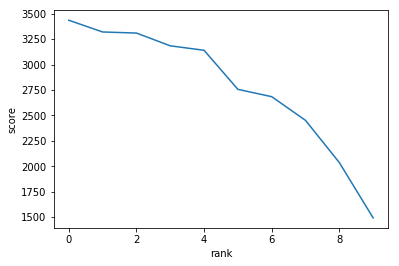

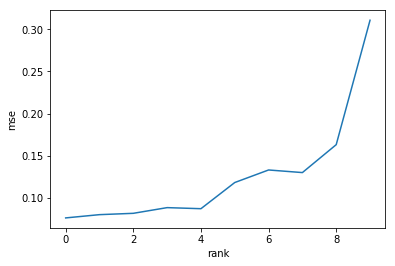

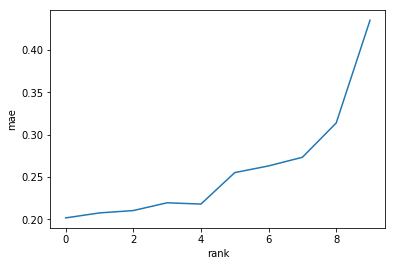

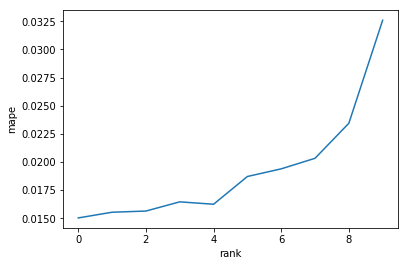

In [30]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

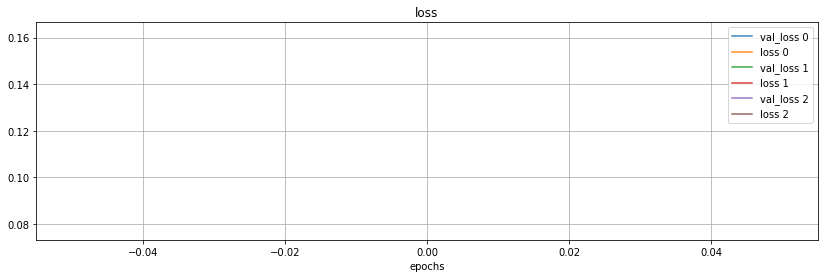

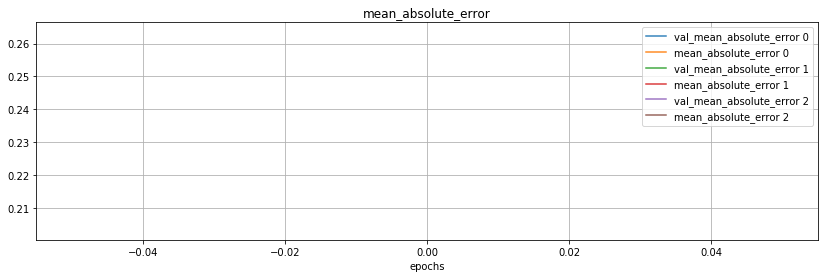

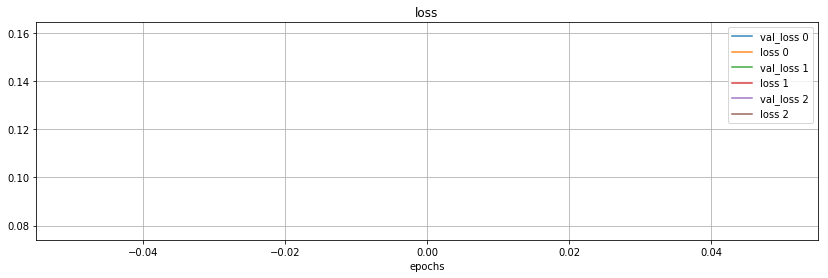

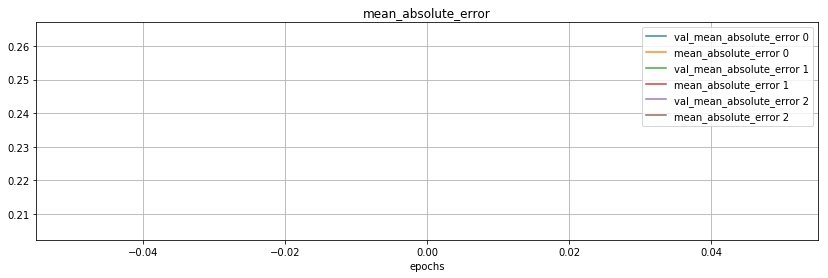

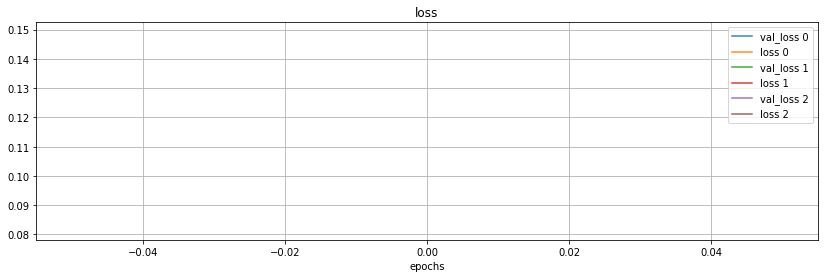

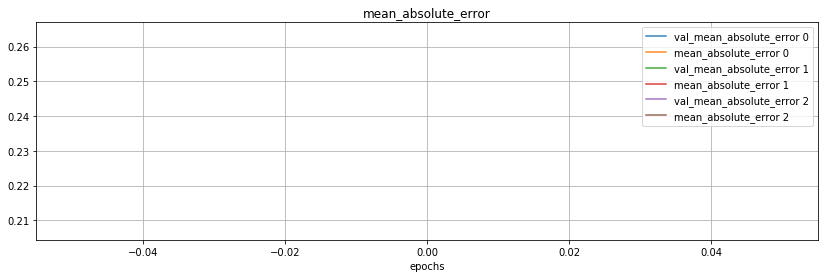

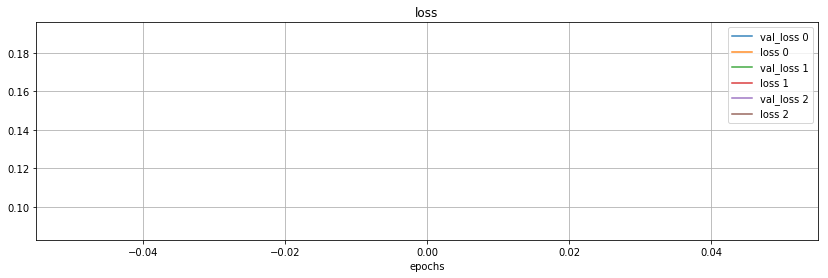

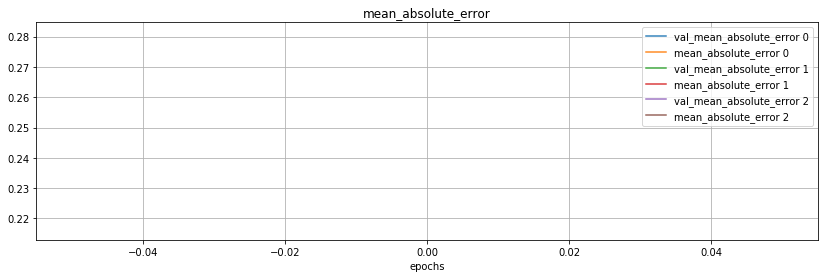

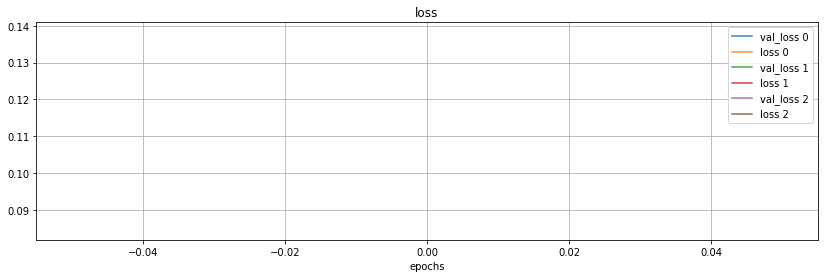

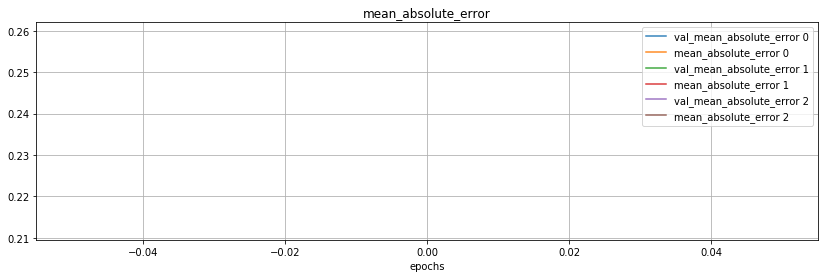

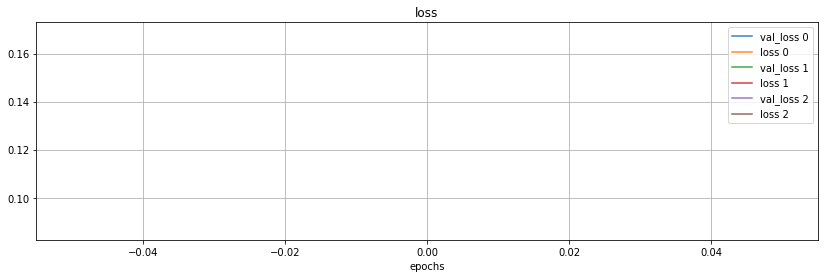

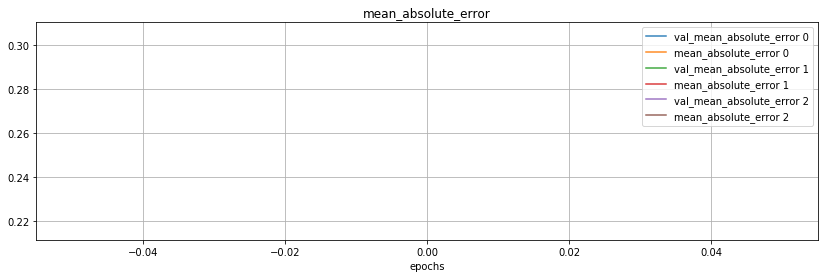

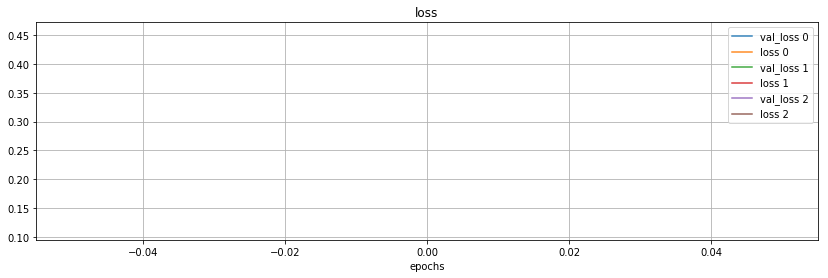

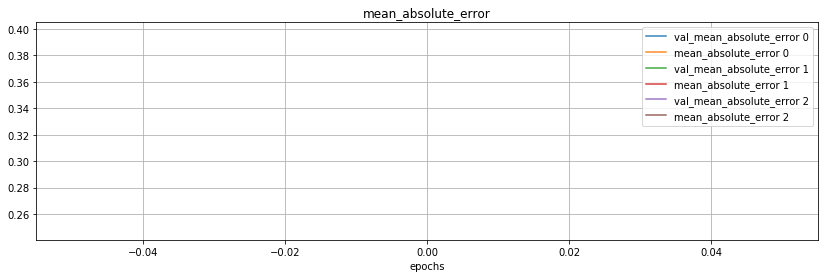

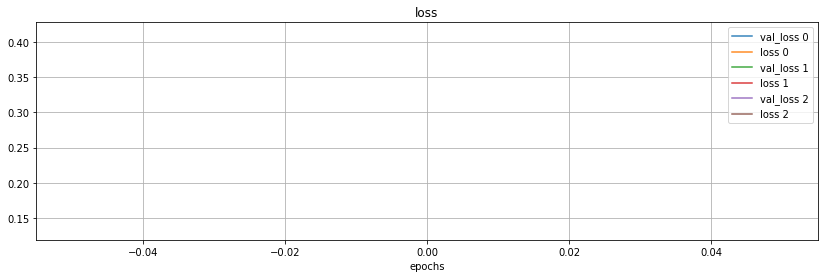

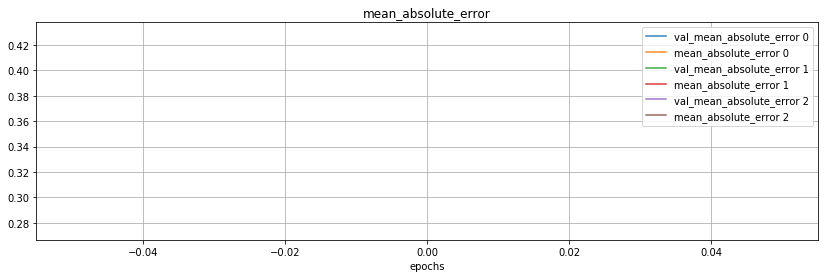

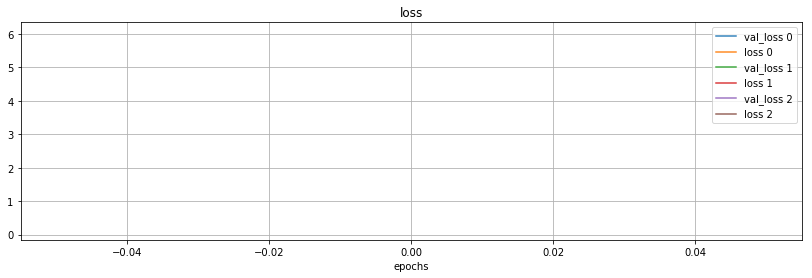

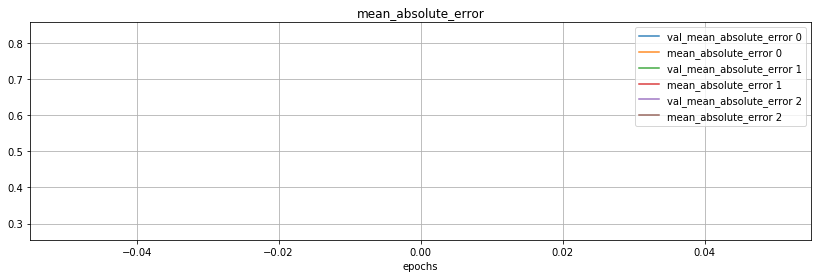

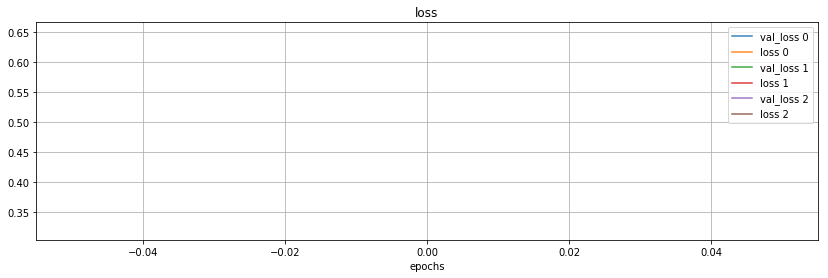

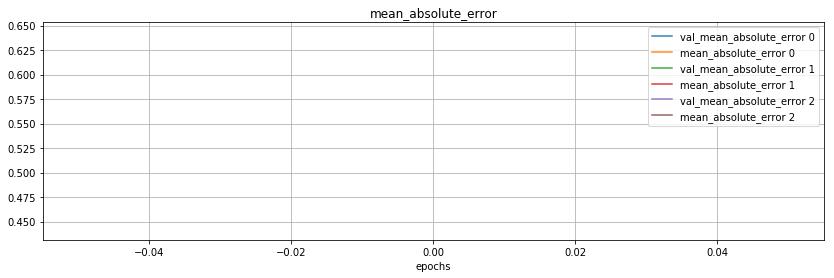

In [26]:
for hists in df_gsearch_results_r['history']:
    plot_list_hist(hists)

In [31]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=7)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['score'][:2], s=7)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

In [32]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=7)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=7)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

#### Hist

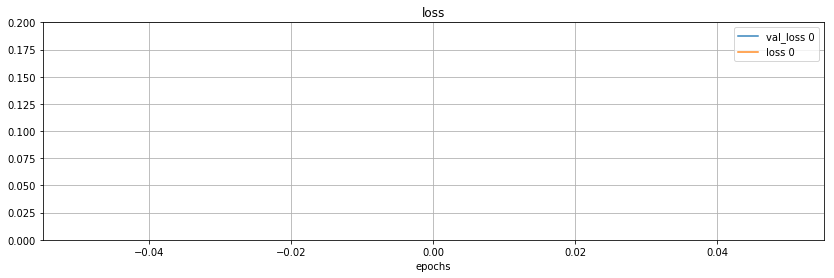

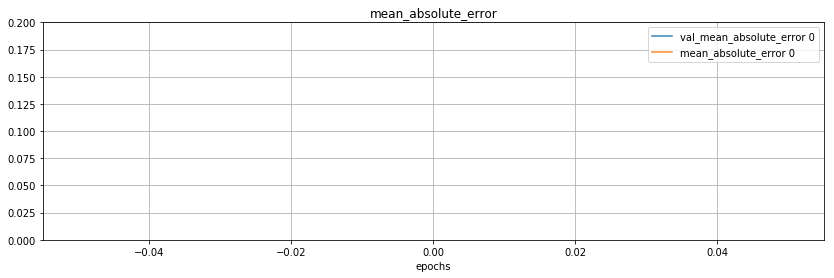

In [57]:
plot_keras_hist(hist, ylim=(0, 0.2))

In [ ]:
hists = gsearch_results[0][5]

In [ ]:
plot_keras_hist(hists)

In [ ]:
plot_keras_hist(hists, ylim=(min(hists[0].history['val_loss']), 
                             min(hists[0].history['val_loss'])+0.01), metrics_plot=['val_loss'])

#### Round 2

In [100]:
params_fix = {'epochs': 200,
              'n_neurons': (1024,)*5+(512,)*5,
              'optimizer': Adam,
              'learning_rate': 0.001,              
             }

In [101]:
params_gsearch = {'batch_size': [64],}
N_fold = 3
N_iter = 1
score_low_bound = 4700 # if score smaller than this, skip the param set

In [102]:
rand_params_set = []
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [103]:
rand_params_set

[{'batch_size': 64}]

In [104]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = dfp.loc[itrain].reset_index(drop=True)
    df_val = dfp.loc[ival].reset_index(drop=True)

    # feat eng
    feat_eng = FeatureEngineering(cols_num=cols_num, 
                                  cols_cat=cols_cat, 
                                  cols_bin=cols_bin, 
                                  col_target=col_target, 
                                  fillna_values=fillna_values, 
                                  cols_right_skew=cols_right_skew,
                                  is_embedding=is_embedding, 
                                  is_tar_encoded=is_tar_encoded,)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Prepare X y matrices
    if is_embedding:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=cols_cat, cols_bin=cols_bin)
    else:
        X_train = build_features_matrices(df_train, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
        X_val = build_features_matrices(df_val, cols_num=cols_num+cols_tar_encoded, cols_cat=[], cols_bin=cols_bin)
    y_train = df_train[col_target+'_scaled']
    y_val = df_val[col_target+'_scaled']
    
    # Compute network size
    n_cols_num_bin = len(cols_num+cols_bin+cols_tar_encoded)
    if is_embedding:
        cat_n_classes = {c: feat_eng.cat_astyper.cat_n_classes[c] for c in cols_cat}
        cat_embed_sizes = {c: int(2*np.log(cat_n_classes[c]+1)+1) for c in cat_n_classes}
    else:
        cat_n_classes = {}
        cat_embed_sizes = {}
    print('Numerical input dims:', n_cols_num_bin)
    print('Embeding  input dims:', cat_n_classes)
    print('Embeding output dims:', cat_embed_sizes)
    print('Total embedding output dims:', np.sum(list(cat_embed_sizes.values())))

    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update( params_rand )
        
        model = build_model(n_cols_num_bin, cat_n_classes, cat_embed_sizes, 
                            n_neurons=params['n_neurons'], learning_rate=params['learning_rate'], 
                            optimizer=params['optimizer'])

        hist = model.fit(x=X_train, y=y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=2,
                         validation_data=(X_val, y_val), callbacks=[GetBest(monitor='val_loss', verbose=0, mode='min')])

        df_val[col_target+'_scaled_pred'] = model.predict(X_val, batch_size=1024)

        feat_eng.target_inverse_transform(df_val, col_target+'_scaled_pred', col_target+'_pred')
        df_val['total_price_pred'] = post_processing(df_val[col_target+'_pred'], df_val)
        
        mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
        mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
        mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
        score = cal_score(df_val['total_price'], df_val['total_price_pred'])
        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(hist)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
Numerical input dims: 205
Embeding  input dims: {'building_material': 10, 'city': 12, 'building_type': 6, 'building_use': 11, 'parking_way': 4, 'town': 211, 'village': 2781, 'encoded_latlon': 7}
Embeding output dims: {'building_material': 5, 'city': 6, 'building_type': 4, 'building_use': 5, 'parking_way': 4, 'town': 11, 'village': 16, 'encoded_latlon': 5}
Total embedding output dims: 56
Train on 40000 samples, validate on 20000 samples
Epoch 1/200
 - 50s - loss: 0.2775 - mean_squared_error: 0.1450 - val_loss: 0.2398 - val_mean_squared_error: 0.1046
Epoch 2/200
 - 52s - loss: 0.2171 - mean_squared_error: 0.0889 - val_loss: 0.2334 - val_mean_squared_error: 0.0963
Epoch 3/200
 - 52s - loss: 0.1983 - mean_squared_error: 0.0760 - val_loss: 0.2003 - val_mean_squared_error: 0.0753
Epoch 4/200
 - 50s - loss: 0.1800 - mean_squared_error: 0.0654 - val_loss: 0.1879 - val_mean_squared_error: 0.0696
Epoch 5/200
 - 52s - loss: 0.1745 - mean_squared_error: 0.0613 - val_loss: 0.1866 -

Epoch 68/200
 - 50s - loss: 0.0492 - mean_squared_error: 0.0076 - val_loss: 0.1596 - val_mean_squared_error: 0.0558
Epoch 69/200
 - 49s - loss: 0.0481 - mean_squared_error: 0.0072 - val_loss: 0.1602 - val_mean_squared_error: 0.0559
Epoch 70/200
 - 48s - loss: 0.0481 - mean_squared_error: 0.0073 - val_loss: 0.1620 - val_mean_squared_error: 0.0570
Epoch 71/200
 - 49s - loss: 0.0481 - mean_squared_error: 0.0072 - val_loss: 0.1607 - val_mean_squared_error: 0.0558
Epoch 72/200
 - 49s - loss: 0.0470 - mean_squared_error: 0.0070 - val_loss: 0.1611 - val_mean_squared_error: 0.0562
Epoch 73/200
 - 51s - loss: 0.0472 - mean_squared_error: 0.0076 - val_loss: 0.1595 - val_mean_squared_error: 0.0553
Epoch 74/200
 - 49s - loss: 0.0462 - mean_squared_error: 0.0067 - val_loss: 0.1610 - val_mean_squared_error: 0.0563
Epoch 75/200
 - 49s - loss: 0.0456 - mean_squared_error: 0.0067 - val_loss: 0.1609 - val_mean_squared_error: 0.0568
Epoch 76/200
 - 50s - loss: 0.0451 - mean_squared_error: 0.0064 - val_lo

Epoch 139/200
 - 55s - loss: 0.0312 - mean_squared_error: 0.0036 - val_loss: 0.1582 - val_mean_squared_error: 0.0552
Epoch 140/200
 - 55s - loss: 0.0294 - mean_squared_error: 0.0040 - val_loss: 0.1594 - val_mean_squared_error: 0.0562
Epoch 141/200
 - 65s - loss: 0.0296 - mean_squared_error: 0.0032 - val_loss: 0.1592 - val_mean_squared_error: 0.0554
Epoch 142/200
 - 60s - loss: 0.0306 - mean_squared_error: 0.0107 - val_loss: 0.1589 - val_mean_squared_error: 0.0559
Epoch 143/200
 - 53s - loss: 0.0301 - mean_squared_error: 0.0034 - val_loss: 0.1593 - val_mean_squared_error: 0.0558
Epoch 144/200
 - 58s - loss: 0.0298 - mean_squared_error: 0.0033 - val_loss: 0.1587 - val_mean_squared_error: 0.0555
Epoch 145/200
 - 52s - loss: 0.0288 - mean_squared_error: 0.0031 - val_loss: 0.1578 - val_mean_squared_error: 0.0553
Epoch 146/200
 - 49s - loss: 0.0304 - mean_squared_error: 0.0033 - val_loss: 0.1578 - val_mean_squared_error: 0.0550
Epoch 147/200
 - 52s - loss: 0.0295 - mean_squared_error: 0.0032

 - 46s - loss: 0.1945 - mean_squared_error: 0.0729 - val_loss: 0.2105 - val_mean_squared_error: 0.0841
Epoch 4/200
 - 47s - loss: 0.1823 - mean_squared_error: 0.0658 - val_loss: 0.1933 - val_mean_squared_error: 0.0726
Epoch 5/200
 - 46s - loss: 0.1740 - mean_squared_error: 0.0607 - val_loss: 0.1913 - val_mean_squared_error: 0.0723
Epoch 6/200
 - 46s - loss: 0.1675 - mean_squared_error: 0.0568 - val_loss: 0.1876 - val_mean_squared_error: 0.0719
Epoch 7/200
 - 46s - loss: 0.1599 - mean_squared_error: 0.0528 - val_loss: 0.1812 - val_mean_squared_error: 0.0668
Epoch 8/200
 - 46s - loss: 0.1553 - mean_squared_error: 0.0497 - val_loss: 0.1900 - val_mean_squared_error: 0.0709
Epoch 9/200
 - 46s - loss: 0.1490 - mean_squared_error: 0.0462 - val_loss: 0.1720 - val_mean_squared_error: 0.0621
Epoch 10/200
 - 46s - loss: 0.1444 - mean_squared_error: 0.0441 - val_loss: 0.1837 - val_mean_squared_error: 0.0676
Epoch 11/200
 - 46s - loss: 0.1392 - mean_squared_error: 0.0414 - val_loss: 0.1710 - val_me

Epoch 74/200
 - 46s - loss: 0.0473 - mean_squared_error: 0.0069 - val_loss: 0.1601 - val_mean_squared_error: 0.0574
Epoch 75/200
 - 46s - loss: 0.0472 - mean_squared_error: 0.0068 - val_loss: 0.1598 - val_mean_squared_error: 0.0573
Epoch 76/200
 - 46s - loss: 0.0459 - mean_squared_error: 0.0065 - val_loss: 0.1596 - val_mean_squared_error: 0.0575
Epoch 77/200
 - 46s - loss: 0.0457 - mean_squared_error: 0.0065 - val_loss: 0.1607 - val_mean_squared_error: 0.0577
Epoch 78/200
 - 46s - loss: 0.0455 - mean_squared_error: 0.0063 - val_loss: 0.1591 - val_mean_squared_error: 0.0566
Epoch 79/200
 - 46s - loss: 0.0443 - mean_squared_error: 0.0061 - val_loss: 0.1598 - val_mean_squared_error: 0.0569
Epoch 80/200
 - 46s - loss: 0.0449 - mean_squared_error: 0.0062 - val_loss: 0.1596 - val_mean_squared_error: 0.0573
Epoch 81/200
 - 45s - loss: 0.0439 - mean_squared_error: 0.0060 - val_loss: 0.1600 - val_mean_squared_error: 0.0573
Epoch 82/200
 - 47s - loss: 0.0435 - mean_squared_error: 0.0059 - val_lo

Epoch 145/200
 - 46s - loss: 0.0296 - mean_squared_error: 0.0032 - val_loss: 0.1582 - val_mean_squared_error: 0.0568
Epoch 146/200
 - 46s - loss: 0.0304 - mean_squared_error: 0.0033 - val_loss: 0.1572 - val_mean_squared_error: 0.0562
Epoch 147/200
 - 46s - loss: 0.0304 - mean_squared_error: 0.0033 - val_loss: 0.1588 - val_mean_squared_error: 0.0574
Epoch 148/200
 - 46s - loss: 0.0295 - mean_squared_error: 0.0031 - val_loss: 0.1579 - val_mean_squared_error: 0.0567
Epoch 149/200
 - 47s - loss: 0.0295 - mean_squared_error: 0.0032 - val_loss: 0.1567 - val_mean_squared_error: 0.0561
Epoch 150/200
 - 47s - loss: 0.0292 - mean_squared_error: 0.0031 - val_loss: 0.1574 - val_mean_squared_error: 0.0563
Epoch 151/200
 - 46s - loss: 0.0284 - mean_squared_error: 0.0031 - val_loss: 0.1575 - val_mean_squared_error: 0.0564
Epoch 152/200
 - 46s - loss: 0.0289 - mean_squared_error: 0.0031 - val_loss: 0.1587 - val_mean_squared_error: 0.0574
Epoch 153/200
 - 46s - loss: 0.0293 - mean_squared_error: 0.0030

Epoch 10/200
 - 46s - loss: 0.1433 - mean_squared_error: 0.0433 - val_loss: 0.1725 - val_mean_squared_error: 0.0634
Epoch 11/200
 - 46s - loss: 0.1393 - mean_squared_error: 0.0410 - val_loss: 0.1719 - val_mean_squared_error: 0.0632
Epoch 12/200
 - 47s - loss: 0.1350 - mean_squared_error: 0.0390 - val_loss: 0.1827 - val_mean_squared_error: 0.0685
Epoch 13/200
 - 47s - loss: 0.1315 - mean_squared_error: 0.0372 - val_loss: 0.1700 - val_mean_squared_error: 0.0621
Epoch 14/200
 - 47s - loss: 0.1268 - mean_squared_error: 0.0351 - val_loss: 0.1740 - val_mean_squared_error: 0.0635
Epoch 15/200
 - 46s - loss: 0.1235 - mean_squared_error: 0.0338 - val_loss: 0.1724 - val_mean_squared_error: 0.0629
Epoch 16/200
 - 46s - loss: 0.1191 - mean_squared_error: 0.0316 - val_loss: 0.1808 - val_mean_squared_error: 0.0686
Epoch 17/200
 - 47s - loss: 0.1166 - mean_squared_error: 0.0304 - val_loss: 0.1737 - val_mean_squared_error: 0.0652
Epoch 18/200
 - 47s - loss: 0.1134 - mean_squared_error: 0.0292 - val_lo

Epoch 81/200
 - 48s - loss: 0.0440 - mean_squared_error: 0.0058 - val_loss: 0.1604 - val_mean_squared_error: 0.0586
Epoch 82/200
 - 47s - loss: 0.0427 - mean_squared_error: 0.0059 - val_loss: 0.1590 - val_mean_squared_error: 0.0589
Epoch 83/200
 - 48s - loss: 0.0427 - mean_squared_error: 0.0055 - val_loss: 0.1599 - val_mean_squared_error: 0.0588
Epoch 84/200
 - 47s - loss: 0.0426 - mean_squared_error: 0.0054 - val_loss: 0.1597 - val_mean_squared_error: 0.0587
Epoch 85/200
 - 47s - loss: 0.0423 - mean_squared_error: 0.0054 - val_loss: 0.1603 - val_mean_squared_error: 0.0589
Epoch 86/200
 - 47s - loss: 0.0423 - mean_squared_error: 0.0053 - val_loss: 0.1595 - val_mean_squared_error: 0.0588
Epoch 87/200
 - 47s - loss: 0.0421 - mean_squared_error: 0.0064 - val_loss: 0.1606 - val_mean_squared_error: 0.0596
Epoch 88/200
 - 47s - loss: 0.0413 - mean_squared_error: 0.0051 - val_loss: 0.1585 - val_mean_squared_error: 0.0580
Epoch 89/200
 - 47s - loss: 0.0408 - mean_squared_error: 0.0050 - val_lo

Epoch 152/200
 - 46s - loss: 0.0299 - mean_squared_error: 0.0030 - val_loss: 0.1576 - val_mean_squared_error: 0.0579
Epoch 153/200
 - 47s - loss: 0.0305 - mean_squared_error: 0.0031 - val_loss: 0.1569 - val_mean_squared_error: 0.0577
Epoch 154/200
 - 47s - loss: 0.0298 - mean_squared_error: 0.0030 - val_loss: 0.1570 - val_mean_squared_error: 0.0577
Epoch 155/200
 - 47s - loss: 0.0309 - mean_squared_error: 0.0032 - val_loss: 0.1577 - val_mean_squared_error: 0.0582
Epoch 156/200
 - 47s - loss: 0.0295 - mean_squared_error: 0.0031 - val_loss: 0.1580 - val_mean_squared_error: 0.0580
Epoch 157/200
 - 46s - loss: 0.0292 - mean_squared_error: 0.0029 - val_loss: 0.1572 - val_mean_squared_error: 0.0574
Epoch 158/200
 - 46s - loss: 0.0304 - mean_squared_error: 0.0031 - val_loss: 0.1576 - val_mean_squared_error: 0.0581
Epoch 159/200
 - 47s - loss: 0.0298 - mean_squared_error: 0.0030 - val_loss: 0.1575 - val_mean_squared_error: 0.0577
Epoch 160/200
 - 46s - loss: 0.0309 - mean_squared_error: 0.0031

In [ ]:
hists = gsearch_results[0][5]

In [105]:
print('Total computing time:', t1-t0)

Total computing time: 28579.714686870575


In [106]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('epochs', 200), ('n_neurons', (1024, 1024, 1024, 1024, 1024, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 5010.503401721518 0.052174035 0.15091588 0.011324741 [4954.842085674405, 5003.840687379241, 5072.827432110906] [0.051094234, 0.052469276, 0.0529586] [0.15171897, 0.1507649, 0.15026379] [0.011382295, 0.011312374, 0.011279553]


In [107]:
metrics = ['score', 'mse', 'mae', 'mape']

In [108]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics]
display(df_gsearch_results)

,batch_size,score,mse,mae,mape
0,64,5010.503402,0.052174,0.150916,0.011325


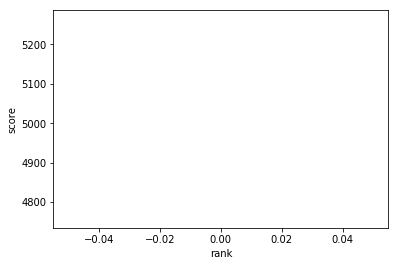

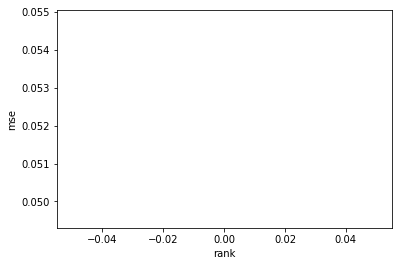

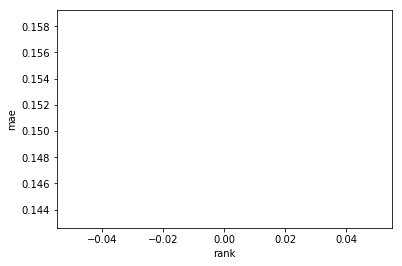

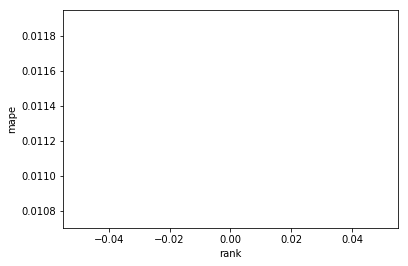

In [109]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

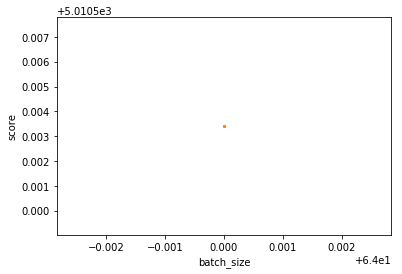

In [110]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=3)
    plt.scatter(df_gsearch_results[p][:2], df_gsearch_results['score'][:2], s=3)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

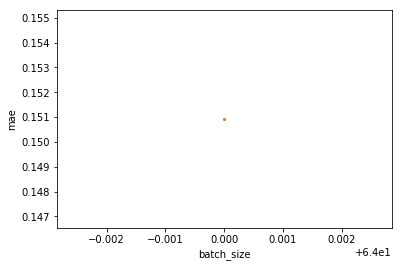

In [111]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=3)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

#### Hist

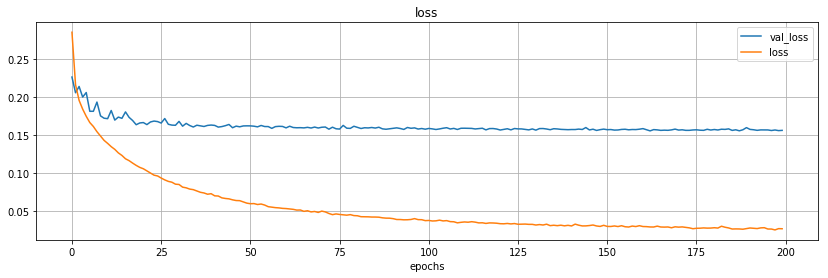

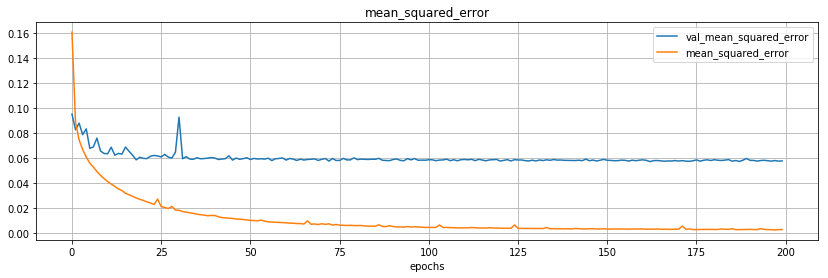

In [112]:
plot_keras_hist(hist)

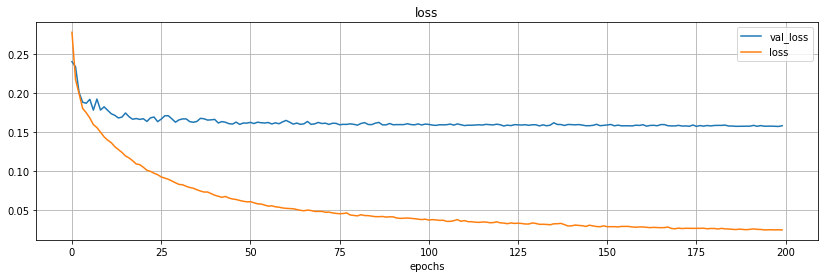

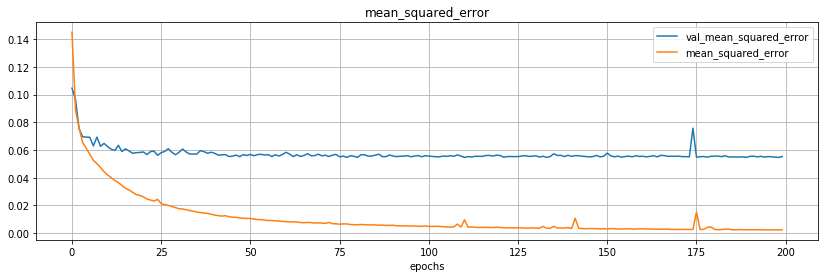

In [113]:
plot_keras_hist(gsearch_results[0][5][0])

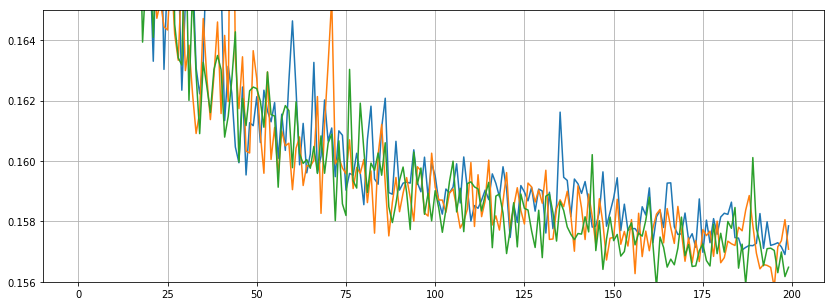

In [114]:
plt.figure(figsize=(14, 5))
for hist in gsearch_results[0][5]:
    plt.plot(hist.history['val_loss'])
plt.ylim(0.156, 0.165)
plt.grid(); plt.show()

### Result

Round 1: 

(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 64)) 4936.5001237591105 0.054168496 0.15317458 0.011494316 [4880.839069649577, 4968.83789165318, 4959.823409974575] [0.05246833, 0.05461397, 0.05542319] [0.15345706, 0.15383308, 0.1522336] [0.011516981, 0.011535957, 0.011430012]
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.0008), ('batch_size', 128)) 4902.5009123335285 0.054754768 0.1548909 0.011611172 [4872.8393027335405, 4920.837021976709, 4913.826412290335] [0.053417027, 0.055927727, 0.054919556] [0.15506728, 0.15528797, 0.15431745] [0.01162971, 0.011635942, 0.011567864]
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.001), ('batch_size', 128)) 4857.500111763676 0.054231703 0.1546625 0.011599835 [4812.838380217552, 4884.839696779847, 4874.822258293629] [0.052770227, 0.054369133, 0.05555574] [0.15476438, 0.15430678, 0.15491636] [0.0116037885, 0.011569585, 0.011626132]
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.0008), ('batch_size', 256)) 4791.496810580294 0.054807622 0.15712523 0.011773665 [4736.835256829858, 4820.838531911373, 4816.816642999649] [0.053222205, 0.05549223, 0.05570843] [0.15762872, 0.15728033, 0.15646665] [0.011823622, 0.0117749255, 0.01172245]
(('epochs', 500), ('n_neurons', (512, 512, 512, 512, 512, 512, 512, 512, 512, 512)), ('optimizer', <class 'keras.optimizers.Adam'>), ('learning_rate', 0.0005), ('batch_size', 256)) 4718.493094210823 0.0547153 0.1577649 0.011829801 [4724.833606645465, 4715.834586530924, 4714.811089456081] [0.052873407, 0.055682763, 0.05558974] [0.1572821, 0.15798627, 0.1580263] [0.011801789, 0.011837361, 0.011850253]